In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/spisaribb"

/content/drive/My Drive/spisaribb


In [ ]:
# Import necessary libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('code'))
from gradcam import *
from zipfile import ZipFile
from fastai.vision import * 
from fastai.metrics import error_rate
from PIL import Image
import matplotlib.pyplot as plt
# constants
path_img = 'images/data'

In [ ]:
# Do initially to extract images from zip
with ZipFile('images/data_2.zip', 'r') as zip: 
    zip.extractall('images')

In [ ]:
tfms = get_transforms(
    do_flip=False,
    max_rotate=120,
    #max_lighting=0.7,
    #max_warp=0.4
)
data = ImageDataBunch.from_folder(path_img, size=640, bs=8, ds_tfms=tfms, padding_mode="border")
data.normalize();
data.show_batch(rows=4, figsize=(20,10))

epoch,train_loss,valid_loss,error_rate,time
0,2.458948,1.293758,0.479167,00:44
1,1.902800,0.976615,0.343750,00:44
2,1.626916,0.448970,0.166667,00:44
3,1.266133,0.389327,0.093750,00:44
4,1.088818,0.320678,0.125000,00:44
5,0.951262,0.263331,0.083333,00:44
6,1.005233,0.194821,0.072917,00:44
7,0.789561,0.154910,0.052083,00:44
8,0.705827,0.211821,0.062500,00:44
9,0.619793,0.537688,0.156250,00:45


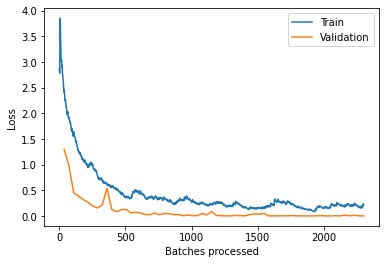

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.fit(64)
#learn.fit_one_cycle(4)
learn.recorder.plot_losses() 

In [ ]:
learn.save('ribb-64')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.990155,0.407774,0.135417,00:59
1,1.007402,0.334653,0.104167,00:56
2,0.908153,0.303104,0.072917,00:56


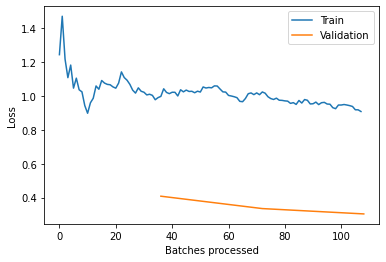

In [ ]:
learn.recorder.plot_losses() 

In [ ]:
learn.load('ribb-64');

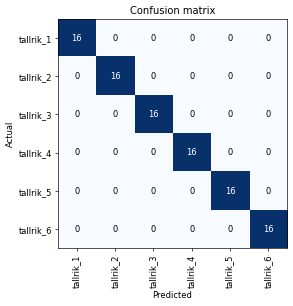

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## GradCAM explanation

In [ ]:
learn.load('ribb-64');

In [ ]:
generate_cam(learn, path_img+'/valid/tallrik_1/1586527524387-0006.png', 1)
generate_cam(learn, path_img+'/valid/tallrik_2/1586527650509-0015.png', 2)
generate_cam(learn, path_img+'/valid/tallrik_3/1586527774489-0010.png', 3)
generate_cam(learn, path_img+'/valid/tallrik_4/1586527881568-0003.png', 4)
generate_cam(learn, path_img+'/valid/tallrik_5/1586527988265-0002.png', 5)
generate_cam(learn, path_img+'/valid/tallrik_6/1586528086152-0010.png', 6)

Output hidden; open in https://colab.research.google.com to view.

# Lime


In [ ]:
pip install lime


In [ ]:
from lime import lime_image
import time
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
learn.load('ribb-64');

In [ ]:
explainer = lime_image.LimeImageExplainer()

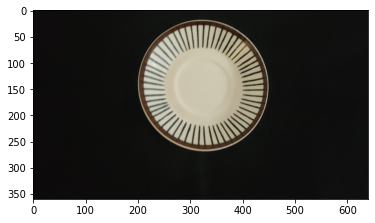

In [ ]:
#Plate 1
#img = Image.open(path_img+'/valid/tallrik_1/1586527524387-0006.png') #Image 1
img = Image.open(path_img+'/valid/tallrik_2/1586527650509-0015.png')
plt.imshow(img)

In [ ]:
#img2 = learn.data.train_ds[0][0]
#img3 = open_image(path_img+'/valid/tallrik_1/1586527524387-0006.png') #Plate 1
img3 = open_image(path_img+'/valid/tallrik_2/1586527650509-0015.png') #plate 2
learn.predict(img3)

(Category tensor(1),
 tensor(1),
 tensor([1.9999e-09, 1.0000e+00, 4.2219e-10, 3.2854e-08, 1.9403e-09, 5.4174e-08]))

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

https://github.com/anurags25/FastAI-LIME/blob/master/LIME-Pets.ipynb


In [ ]:

# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)


In [ ]:
img_t = get_input_tensors(img)

In [ ]:
learn.model.eval();

In [ ]:
# cuda so it is sent to GPU
logits = learn.model(img_t.cuda())
#logits = learn.predict(img3)

In [ ]:
logits

(Category tensor(1),
 tensor(1),
 tensor([1.9999e-09, 1.0000e+00, 4.2219e-10, 3.2854e-08, 1.9403e-09, 5.4174e-08]))

In [ ]:
#convert back to local mem
# Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 3 predictions.
probs = F.softmax(logits.cpu(), dim=1)
probs5 = probs.topk(3)
platelabel = ['Plate 1', 'Plate 2', 'Plate 3', 'Plate 4', 'Plate 5', 'Plate 6']
tuple((p,c, platelabel[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy())) #No nice names
#tuple((p,c) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((1.0, 5, 'Plate 6'),
 (2.9748184e-08, 3, 'Plate 4'),
 (2.8435185e-11, 2, 'Plate 3'))

In [ ]:
#For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.
#Perhaps questionable to do this???? think fast and slow
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    learn.model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    learn.model.to(device)
    batch = batch.to(device)
    
    logits = learn.model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
#test our function for the sample image.
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

5

In [ ]:
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [ ]:
from skimage.segmentation import mark_boundaries

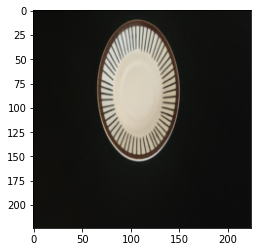

In [ ]:
#mask on image and see the areas that are encouraging the top prediction.
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

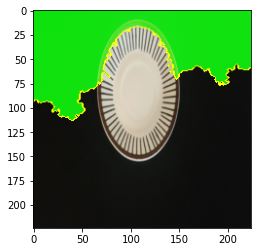

In [ ]:
# areas that contributes against the top prediction
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

#Shap

#Scrap

In [5]:
#!git add *.ipynb;
!git commit -m "Next commit";
#!git push -u origin master;

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
	modified:   code.ipynb

Untracked files:
	setup.ipynb

no changes added to commit


In [ ]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.
